Q1.  
[10] Eigenfaces 
1. data partition 하기
2. S=(1/N)AAT : train data에 PCA 적용
 including: the eigenvectors, the eigenvalues, and the mean image, how many eigenvectors with non-zero eigenvalues are obtained and how many eigenvectors are to be used for face recognition.
3. S=(1/N)ATA : train data에 PCA 적용, 2와 비교
 including: if the eigenvectors and eigenvalues obtained are identical, what are the pros/cons of each method. (Show respective measurements)

In [1]:
import sys
import os
sys.path.append('../')

from dataset.data import split_data
from question1 import eigen

from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def memory_usage(message=''):
    # current process RAM usage
    p = psutil.Process()
    rss = p.memory_info().rss / 2 ** 20 # Bytes to MB
    print(f"[{message}] memory usage: {rss: 10.5f} MB")

In [4]:
# 1. split data using data.py function
train_data, train_label, test_data, test_label = split_data(data_path="../dataset/face.mat")
mean_face = np.mean(train_data, axis=1).reshape(-1, 1)

In [5]:
## 2. S=(1/N)AAT
val1, vec1 = eigen.pca(train_data, mean_face, low=False)

## 3. S=(1/N)ATA
val2, vec2 = eigen.pca(train_data, mean_face)

Two eigenvalues are identical
Two eigenvectors are identical


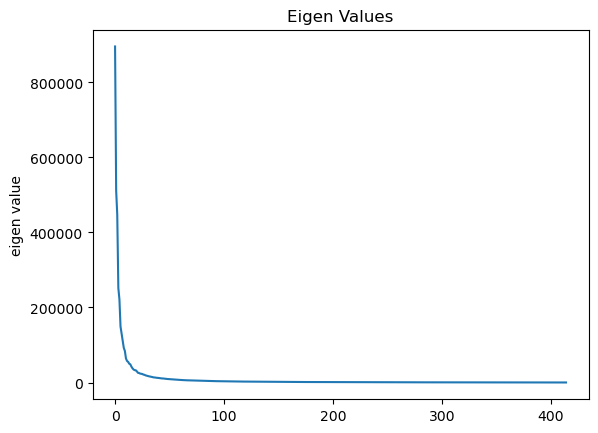

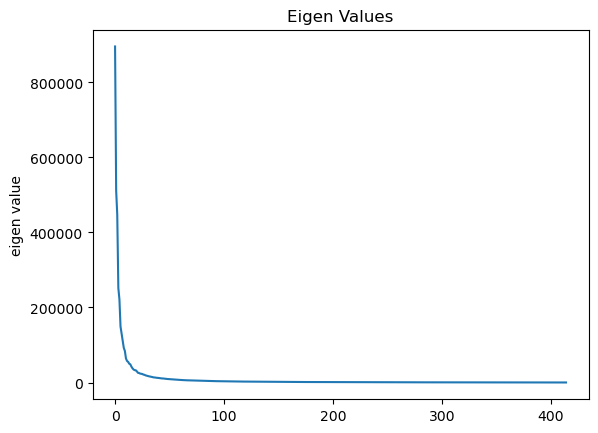

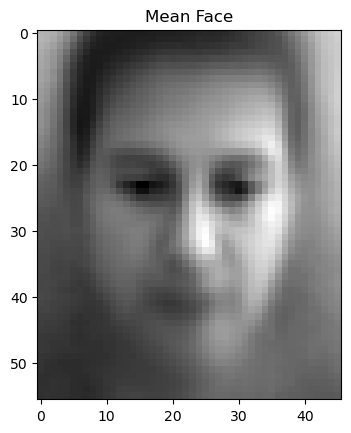

90 percent eigenvalue number:  65
95 percent eigenvalue number:  122
99 percent eigenvalue number:  269


In [5]:
M = 415
if (np.isclose(val1[:M], val2[:M], rtol=1e-5, atol=1e-8).all()):
    print("Two eigenvalues are identical")

if (np.isclose(abs(vec1[:, :M]), abs(vec2[:, :M]), rtol=1e-5, atol=1e-8).all()):
    print("Two eigenvectors are identical")

# the eigenvectors, the eigenvalues
eigen.plot_eig_val(val1[:M])
eigen.plot_eig_val(val2[:M])

# mean image
mean_img = eigen.mean_face_reconstruction(mean_face)

"""
추가할 점: how many eigenvectors with non-zero eigenvalues are 
obtained and how many eigenvectors are to be used for face recognition
"""
eigenval_percent = val2 / np.sum(val2)
cur_percent = 0.0
cnt = 0
for num, i in enumerate(eigenval_percent):
    cur_percent += i
    if (cur_percent > 0.90 and cnt == 0): 
        print("90 percent eigenvalue number: ", num)
        cnt+=1
    if (cur_percent > 0.95 and cnt == 1): 
        print("95 percent eigenvalue number: ", num)
        cnt+=1
    if (cur_percent > 0.99): 
        print("99 percent eigenvalue number: ", num)
        break

[15] Application of Eigenfaces (low PCA)
1. face image reconstruction 
 변수: varying the number of bases 
 including: if the reconstruction error (or the distortion measure) obtained is same as in the theory, how good the reconstruction / results are for at least 3 images of your choice (e.g. from both the training and testing dataset). 
2. PCA-based face recognition 
 변수: 아키텍쳐에서 사용된 parameter를 달리하여 실험할 것
 including: accuracy, example success and failure cases, the confusion matrices, time/memory

Text(0.5, 1.0, 'Test data reconstruction error according to the number of bases')

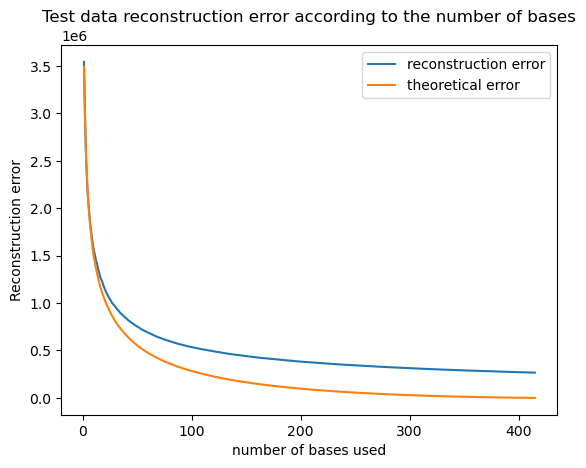

In [6]:
# 1. reconstruction error corresponding to number of bases
# eigenvalue가 작을수록 small detail과 관련이 있어서 test data reconstruction에서 
# error가 커진다 (?)
re_error = []
th_error = []
for i in range (1, 416):
    th, re = eigen.face_reconstruction(test_data, val2, vec2, mean_face, M = i)
    th_error.append(th)
    re_error.append(re)

th_error = np.array(th_error)
re_error = np.array(re_error)

# draw graph
graph = plt.figure()
ax1 = graph.add_subplot(111)
X = np.arange(1, 416)
ax1.plot(X, re_error, label='reconstruction error')
ax1.plot(X, th_error, label='theoretical error')
ax1.set_ylabel('Reconstruction error')
ax1.set_xlabel('number of bases used')

plt.legend()
plt.title('Test data reconstruction error according to the number of bases')

Text(0.5, 1.0, 'Test data reconstruction error according to the number of PCA bases')

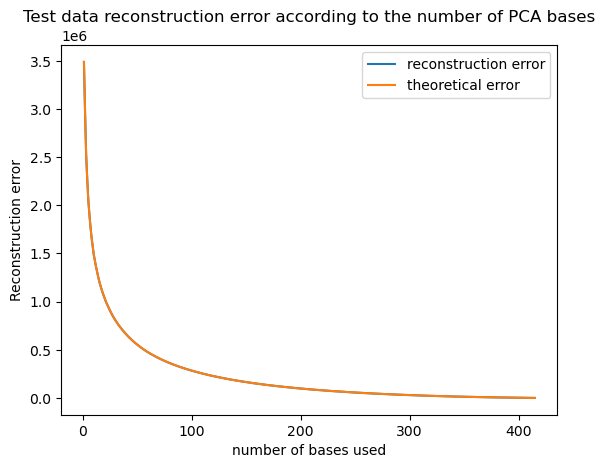

In [7]:
# 위 코드 동일, train data version: theory와 reconstruction error 동일
re_error = []
th_error = []
for i in range (1, 416):
    th, re = eigen.face_reconstruction(train_data, val2, vec2, mean_face, M = i)
    th_error.append(th)
    re_error.append(re)

th_error = np.array(th_error)
re_error = np.array(re_error)

# draw graph
graph = plt.figure()
ax1 = graph.add_subplot(111)
X = np.arange(1, 416)
ax1.plot(X, re_error, label='reconstruction error')
ax1.plot(X, th_error, label='theoretical error')
ax1.set_ylabel('Reconstruction error')
ax1.set_xlabel('number of bases used')

plt.legend()
plt.title('Test data reconstruction error according to the number of PCA bases')

In [8]:
# reconstruction result image: at leat 3 images, from both train & test data

In [9]:
def pca_transform (data, eig_val, eig_vec, mean_face, M=50):
    centered_data = data - mean_face
    projected_data = eig_vec[:, :M].T @ centered_data
    return projected_data

In [10]:
##### test #####

train_PCA_data = pca_transform(train_data, val2, vec2, mean_face, M = 100)
test_PCA_data = pca_transform(test_data, val2, vec2, mean_face, M = 100)

model = KNeighborsClassifier(n_neighbors=5, weights='uniform')
model.fit(train_PCA_data.T, train_label)
result = model.score(test_PCA_data.T, test_label)
memory_usage()
print(model.predict(test_PCA_data.T))
print(result)

test_pred = eigen.knn_classifier(train_data, train_label, test_data, k=5, M=100)
accuracy = np.mean(test_pred == test_label)
print(test_pred)
print(accuracy)

[] memory usage:  258.34375 MB
[ 1 42  8  5  3  3  4  4  5  5 21 17  7  7  8  8 37  9  7 10 10 11 12 12
 13 13 34 14 15 15 14  7 30 17 39 18 21 21 20 16 21 21 22 10 29 23  4  4
 29 25  6 12 25 27 28 28 14 47 30 29 31 31 32  8 29 33 34 35 40 29 28 31
 37 37  6 10 28 39 35 40 30 35 26 30 14 29  1 29 39 32 46 46  7 14 48 49
 32 14 37 39 51 38 40 32]
0.4423076923076923
[ 1 42  8  5  3  3  4  4  5  5 21 17  7  7  8  8 37  9  7 10 10 11 12 12
 13 13 34 14 15 15 14  7 30 17 39 18 21 21 20 16 21 21 22 10 29 23  4  4
 29 25  6 12 25 27 28 28 14 47 30 29 31 31 32  8 29 33 34 35 40 29 28 31
 37 37  6 10 28 39 35 40 30 35 26 30 14 29  1 29 39 32 46 46  7 14 48 49
 32 14 37 39 51 38 40 32]
0.4423076923076923


In [ ]:
# 2. PCA-KNN classification
max_acc = 0
max_k = 0
max_M = 0

acc_knn = np.zeros((5, 415))
for i in range(5):
    for j in range (1, 416):
        train_PCA_data = eigen.pca_transform(train_data, val2, vec2, mean_face, M = j)
        test_PCA_data = eigen.pca_transform(test_data, val2, vec2, mean_face, M = j)

        n_neighbors = 2 * i + 1
        model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='uniform')
        model.fit(train_PCA_data.T, train_label)
        result = model.score(test_PCA_data.T, test_label)
        acc_knn[i][j-1] = result
    print(n_neighbors,"-nn neighbors batch end")
    
#io.savemat('knn-pca1.mat', {'accuracy':acc_knn})


1 -nn neighbors batch end
3 -nn neighbors batch end
5 -nn neighbors batch end
7 -nn neighbors batch end
9 -nn neighbors batch end


(5, 415)
89 0.6153846153846154


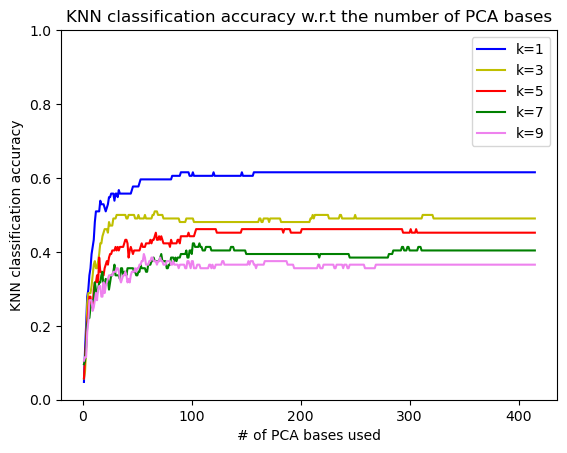

In [8]:
# PCA-KNN accuracy plot
base_dir = os.getcwd()  
full_data_path = os.path.join(base_dir, "./knn-pca1.mat")
knn_acc = io.loadmat(full_data_path)
knn_acc = np.array(knn_acc["accuracy"])

print(knn_acc.shape)
graph = plt.figure()
ax1 = graph.add_subplot(111)
ax1.set_ylim([0.0, 1.0])
X = np.arange(1, 416)

ax1.plot(X, knn_acc[0, :], color='b', label='k=1')
ax1.plot(X, knn_acc[1, :], color='y', label='k=3')
ax1.plot(X, knn_acc[2, :], color='r', label='k=5')
ax1.plot(X, knn_acc[3, :], color='g', label='k=7')
ax1.plot(X, knn_acc[4, :], color='violet', label='k=9')

ax1.set_ylabel('KNN classification accuracy')
ax1.set_xlabel('# of PCA bases used')

plt.legend()
plt.title('KNN classification accuracy w.r.t the number of PCA bases')

print(np.argmax(knn_acc[0, :]), knn_acc[0, np.argmax(knn_acc[0, :])])

In [10]:
# PCA-KNN accuracy plot
"""
90 percent eigenvalue number:  65
95 percent eigenvalue number:  122
99 percent eigenvalue number:  269
"""
pca_num = [5, 10, 20, 30, 60, 120, 180, 240, 300]
acc_knn = np.zeros((len(pca_num), 70))
for i in range(len(pca_num)):
    train_PCA_data = eigen.pca_transform(train_data, val2, vec2, mean_face, M = pca_num[i])
    test_PCA_data = eigen.pca_transform(test_data, val2, vec2, mean_face, M = pca_num[i])
    for j in range (0, 70):
        n_neighbors = 2 * j + 1
        model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='uniform')
        model.fit(train_PCA_data.T, train_label)
        result = model.score(test_PCA_data.T, test_label)
        acc_knn[i][j] = result
    print(pca_num[i],"-number of eigenval end")
    
#io.savemat('knn-pca2.mat', {'accuracy':acc_knn})

5 -number of eigenval end
10 -number of eigenval end
20 -number of eigenval end
30 -number of eigenval end
60 -number of eigenval end
120 -number of eigenval end
180 -number of eigenval end
240 -number of eigenval end
300 -number of eigenval end


(9, 70)


Text(0.5, 1.0, 'KNN classification accuracy w.r.t the number of NN neighbors')

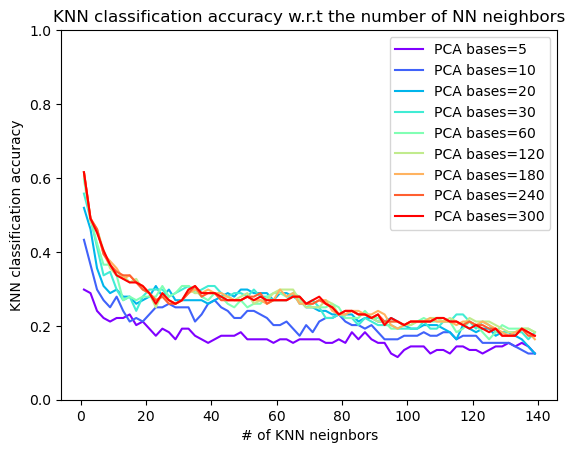

In [12]:
# PCA-KNN accuracy plot
base_dir = os.getcwd()  
full_data_path = os.path.join(base_dir, "./knn-pca2.mat")
knn_acc = io.loadmat(full_data_path)
knn_acc = np.array(knn_acc["accuracy"])

print(knn_acc.shape)
graph = plt.figure()
ax1 = graph.add_subplot(111)
ax1.set_ylim([0.0, 1.0])
X = np.arange(1, 141, 2)

color = plt.cm.rainbow(np.linspace(0, 1, len(pca_num)))
for i, c in enumerate (color):
    ax1.plot(X, knn_acc[i, :], color=c, label='PCA bases={}'.format(pca_num[i]))

ax1.set_ylabel('KNN classification accuracy')
ax1.set_xlabel('# of KNN neignbors')

plt.legend()
plt.title('KNN classification accuracy w.r.t the number of NN neighbors')